In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
train_df = pd.read_csv('../input/spaceship-titanic/train.csv')
test_df = pd.read_csv('../input/spaceship-titanic/test.csv')
sample_submission_df = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
train_df.head() #HomePlanet, Age, Destination, VIP, Transported

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
#verify if they have null values
train_df.isna().sum()
#for those strings = NaN; values = median, 

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [6]:
values = ['Age', 'RoomService',  'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
strings = ['HomePlanet', 'Cabin', 'Destination']
binary = ['CryoSleep', 'VIP'] 

for i in values:
    train_df[i] = train_df[i].fillna(train_df[i].median())
for i in strings, binary:
    train_df[i] = train_df[i].fillna(train_df[i]=='NaN')



In [7]:
train_df.isna().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            200
Transported       0
dtype: int64

In [8]:
train_df['HomePlanet'].value_counts()

HomePlanet
Earth     4602
Europa    2131
Mars      1759
False      201
Name: count, dtype: int64

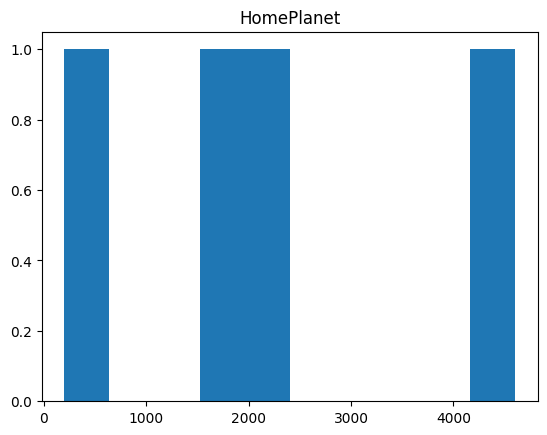

value counts HomePlanet
Earth     4602
Europa    2131
Mars      1759
False      201
Name: count, dtype: int64


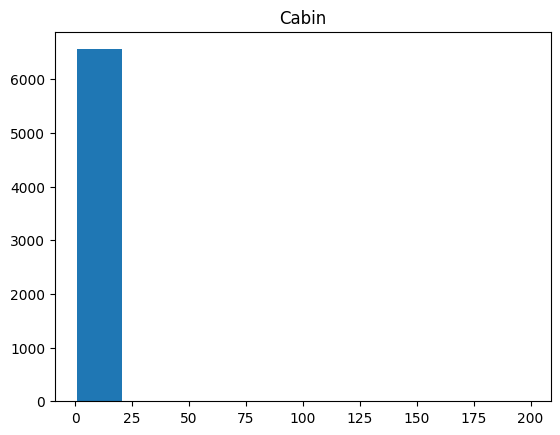

value counts Cabin
False      199
G/734/S      8
C/137/S      7
B/201/P      7
G/109/P      7
          ... 
G/556/P      1
E/231/S      1
G/545/S      1
G/543/S      1
C/178/S      1
Name: count, Length: 6561, dtype: int64


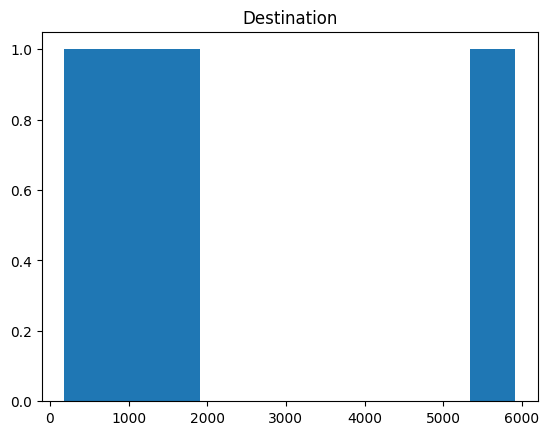

value counts Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
False             182
Name: count, dtype: int64


In [9]:
for i in strings:
    plt.hist(train_df[i].value_counts())
    plt.title(i)
    plt.show()
    print('value counts', train_df[i].value_counts())

In [10]:
#necessary to divide Cabin for 3 different columns: deck/num/side
train_df['Cabin'].head()

0    B/0/P
1    F/0/S
2    A/0/S
3    A/0/S
4    F/1/S
Name: Cabin, dtype: object

In [11]:
train_df[['deck', 'num', 'side']] = train_df['Cabin'].str.split('/', expand=True)
train_df = train_df.drop('Cabin', axis=1)
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


In [12]:
test_df[['deck', 'num', 'side']] = test_df['Cabin'].str.split('/', expand=True)
test_df = test_df.drop('Cabin', axis=1)
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,deck,num,side
0,0013_01,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,G,3,S
1,0018_01,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,F,4,S
2,0019_01,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,C,0,S
3,0021_01,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,C,1,S
4,0023_01,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,F,5,S


In [13]:
#boolean to binary:
for i in binary:
    train_df[i] = train_df[i].map({True: 1, False: 0})
    test_df[i] = test_df[i].map({True: 1, False: 0})

In [14]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side
0,0001_01,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


In [15]:
#deck to 1 to 8 and side to 0 to 1:
train_df['deck'] = train_df['deck'].map({'A': 1, 'B': 2, 'C': 3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8})
train_df['side'] = train_df['side'].map({'P': 1, 'S': 0})

test_df['deck'] = test_df['deck'].map({'A': 1, 'B': 2, 'C': 3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8})
test_df['side'] = test_df['side'].map({'P': 1, 'S': 0})

train_df['deck'].value_counts()

deck
6.0    2794
7.0    2559
5.0     876
2.0     779
3.0     747
4.0     478
1.0     256
8.0       5
Name: count, dtype: int64

In [16]:
train_df['deck'].isna().sum()

199

In [17]:
train_df['num'].isna().sum()

199

In [18]:
remove_null = ['deck', 'num', 'side']
for i in remove_null:
    train_df[i] = pd.to_numeric(train_df[i], errors='coerce')
    train_df[i].fillna(train_df[i].median(), inplace=True)
    test_df[i] = pd.to_numeric(test_df[i], errors='coerce')
    test_df[i].fillna(test_df[i].median(), inplace=True)
test_df['deck'].isna().sum()

/tmp/ipykernel_18/475534580.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[i].fillna(train_df[i].median(), inplace=True)
/tmp/ipykernel_18/475534580.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

0

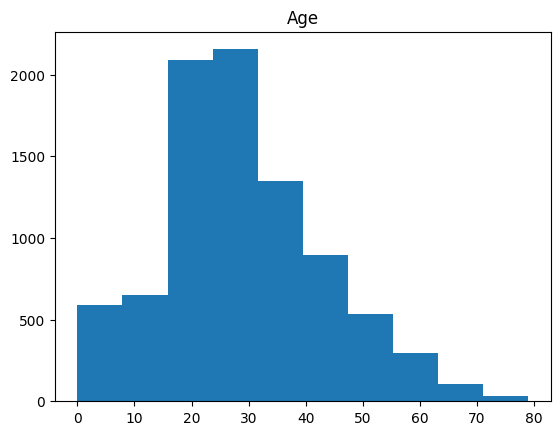

Average: 28.790291038766824 Max: 79.0 Min: 0.0


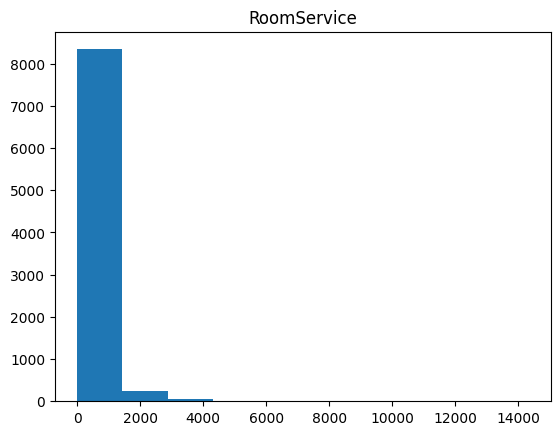

Average: 220.0093178419418 Max: 14327.0 Min: 0.0


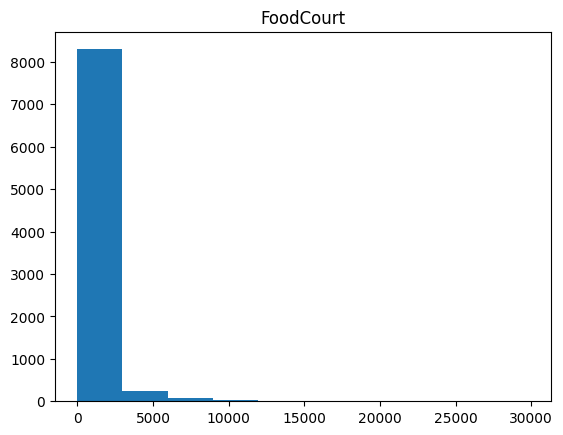

Average: 448.4340273783504 Max: 29813.0 Min: 0.0


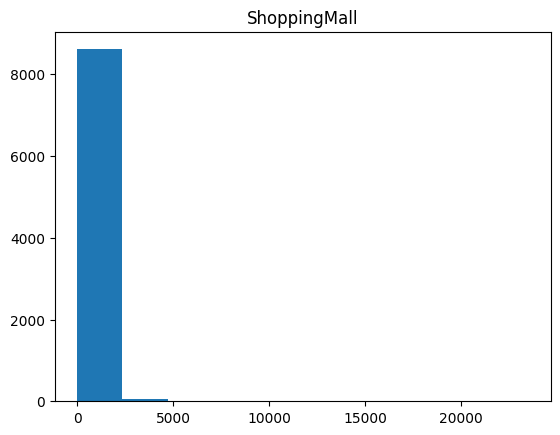

Average: 169.57229955136316 Max: 23492.0 Min: 0.0


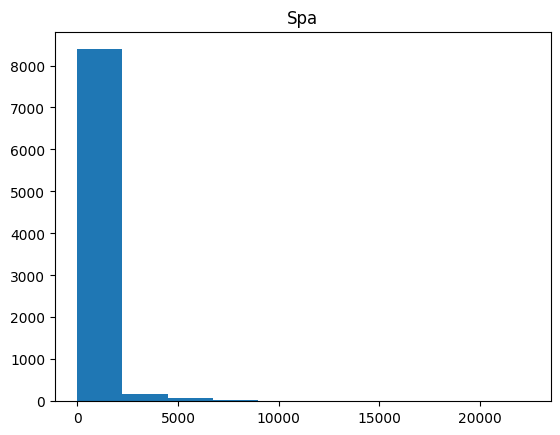

Average: 304.5888646037041 Max: 22408.0 Min: 0.0


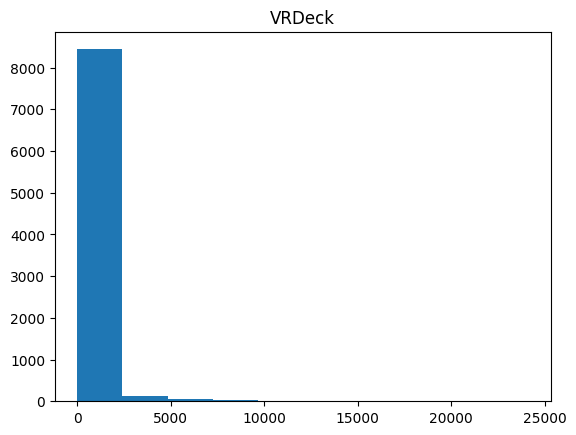

Average: 298.2618198550558 Max: 24133.0 Min: 0.0


In [19]:
for i in values:
    plt.hist(train_df[i])
    plt.title(i)
    plt.show()
    print("Average:",train_df[i].mean(),
         "Max:", train_df[i].max(),
         "Min:", train_df[i].min())

In [20]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side
0,0001_01,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,2.0,0.0,1.0
1,0002_01,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,6.0,0.0,0.0
2,0003_01,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,1.0,0.0,0.0
3,0003_02,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,1.0,0.0,0.0
4,0004_01,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,6.0,1.0,0.0


In [21]:
test_df['HomePlanet'].value_counts()

HomePlanet
Earth     2263
Europa    1002
Mars       925
Name: count, dtype: int64

In [22]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   float64
 3   Destination   4185 non-null   object 
 4   Age           4186 non-null   float64
 5   VIP           4184 non-null   float64
 6   RoomService   4195 non-null   float64
 7   FoodCourt     4171 non-null   float64
 8   ShoppingMall  4179 non-null   float64
 9   Spa           4176 non-null   float64
 10  VRDeck        4197 non-null   float64
 11  Name          4183 non-null   object 
 12  deck          4277 non-null   float64
 13  num           4277 non-null   float64
 14  side          4277 non-null   float64
dtypes: float64(11), object(4)
memory usage: 501.3+ KB


In [23]:
#change strings to columns with values 
#first fill na with the most comum string
transform = ['HomePlanet', 'Destination']
for i in transform:
    train_df[i].fillna(train_df[i].mode()[0], inplace=True)
    test_df[i].fillna(test_df[i].mode()[0], inplace=True)

#One-Hot Encoding    
#test_df = pd.get_dummies(test_df, columns=transform, drop_first=True)
#train_df = pd.get_dummies(train_df, columns=transform, drop_first=True)

/tmp/ipykernel_18/1439772236.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[i].fillna(train_df[i].mode()[0], inplace=True)
/tmp/ipykernel_18/1439772236.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

In [24]:
test_df['HomePlanet'].value_counts()

HomePlanet
Earth     2350
Europa    1002
Mars       925
Name: count, dtype: int64

In [25]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4277 non-null   object 
 2   CryoSleep     4184 non-null   float64
 3   Destination   4277 non-null   object 
 4   Age           4186 non-null   float64
 5   VIP           4184 non-null   float64
 6   RoomService   4195 non-null   float64
 7   FoodCourt     4171 non-null   float64
 8   ShoppingMall  4179 non-null   float64
 9   Spa           4176 non-null   float64
 10  VRDeck        4197 non-null   float64
 11  Name          4183 non-null   object 
 12  deck          4277 non-null   float64
 13  num           4277 non-null   float64
 14  side          4277 non-null   float64
dtypes: float64(11), object(4)
memory usage: 501.3+ KB


In [26]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side
0,0001_01,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,2.0,0.0,1.0
1,0002_01,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,6.0,0.0,0.0
2,0003_01,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,1.0,0.0,0.0
3,0003_02,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,1.0,0.0,0.0
4,0004_01,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,6.0,1.0,0.0


In [27]:
train_df = pd.get_dummies(train_df, columns=['HomePlanet'])
train_df = pd.get_dummies(train_df, columns=['Destination'])
test_df = pd.get_dummies(test_df, columns=['HomePlanet'])
test_df = pd.get_dummies(test_df, columns=['Destination'])


In [28]:
test_df.columns

Index(['PassengerId', 'CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'deck', 'num', 'side',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e'],
      dtype='object')

In [29]:
train_df.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,...,num,side,HomePlanet_False,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_False,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0001_01,0,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,...,0.0,1.0,False,False,True,False,False,False,False,True
1,0002_01,0,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,...,0.0,0.0,False,True,False,False,False,False,False,True
2,0003_01,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,...,0.0,0.0,False,False,True,False,False,False,False,True
3,0003_02,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,...,0.0,0.0,False,False,True,False,False,False,False,True
4,0004_01,0,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,...,1.0,0.0,False,True,False,False,False,False,False,True


In [30]:
train_df = train_df.rename(columns={"HomePlanet_Earth": "Earth", "HomePlanet_Europa": "Europa", "HomePlanet_Mars": "Mars",
                                   "Destination_55 Cancri e": "Cancri", "Destination_PSO J318.5-22": "J318", "Destination_TRAPPIST-1e": "TRAPPIST"})
test_df = test_df.rename(columns={"HomePlanet_Earth": "Earth", "HomePlanet_Europa": "Europa", "HomePlanet_Mars": "Mars",
                                   "Destination_55 Cancri e": "Cancri", "Destination_PSO J318.5-22": "J318", "Destination_TRAPPIST-1e": "TRAPPIST"})

In [31]:
test_df.isnull().sum()

PassengerId       0
CryoSleep        93
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
deck              0
num               0
side              0
Earth             0
Europa            0
Mars              0
Cancri            0
J318              0
TRAPPIST          0
dtype: int64

In [32]:
test_null_values = ['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for i in test_null_values:
    test_df[i] = test_df[i].fillna(test_df[i].median())
test_df.isnull().sum()

PassengerId      0
CryoSleep        0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Name            94
deck             0
num              0
side             0
Earth            0
Europa           0
Mars             0
Cancri           0
J318             0
TRAPPIST         0
dtype: int64

In [33]:
test_df.columns

Index(['PassengerId', 'CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'deck', 'num', 'side', 'Earth',
       'Europa', 'Mars', 'Cancri', 'J318', 'TRAPPIST'],
      dtype='object')

In [34]:
train_df.columns

Index(['PassengerId', 'CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported', 'deck', 'num',
       'side', 'HomePlanet_False', 'Earth', 'Europa', 'Mars',
       'Destination_False', 'Cancri', 'J318', 'TRAPPIST'],
      dtype='object')

In [35]:
train_df = train_df.drop(['Destination_False', 'HomePlanet_False'], axis=1)
train_df.columns

Index(['PassengerId', 'CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported', 'deck', 'num',
       'side', 'Earth', 'Europa', 'Mars', 'Cancri', 'J318', 'TRAPPIST'],
      dtype='object')

In [36]:
X = train_df.drop(['PassengerId', 'Transported', 'Name'], axis=1)
y = train_df['Transported']
X_test = test_df.drop(['PassengerId', 'Name'], axis=1)

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X)
#X_test_scaled = scaler.transform(X_test)

#print(f'Acurácia na validação: {accuracy_score(y_val, y_pred):.2f}')
#test_pred = model.predict(X_test)

In [38]:
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [39]:
logistic_regression = LogisticRegression(random_state=42, max_iter=500)
logistic_regression.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=42)

In [40]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [41]:
X_test.isnull().sum()

CryoSleep       0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
deck            0
num             0
side            0
Earth           0
Europa          0
Mars            0
Cancri          0
J318            0
TRAPPIST        0
dtype: int64

In [42]:
y_pred_rf = random_forest.predict(X_test)
y_pred_lr = logistic_regression.predict(X_test)
y_pred_dt = decision_tree.predict(X_test)

In [43]:
acc_rf = round(random_forest.score(X_train, y_train) * 100, 2)
acc_lr = round(logistic_regression.score(X_train, y_train) * 100, 2)
acc_dt = round(decision_tree.score(X_train, y_train) * 100, 2)

In [44]:
#trying to improve random forest parameters 
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [45]:
from sklearn.ensemble import RandomForestRegressor
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  18.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  12.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  15.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  14.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=  14.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   9.9s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   9.2s
[CV] END bootstrap=False, max_depth=100,

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   4.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  18.3s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time= 1.1min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   9.4s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  12.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  39.9s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   9.5s
[CV] END bootstrap=True, max_depth=70,

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   4.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  12.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  11.9s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time= 1.2min
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   8.2s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  37.9s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=  52.3s
[CV] END bootstrap=False, max_depth=1

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [46]:
rf_random.best_params_
#{'n_estimators': 800,
# 'min_samples_split': 2,
#'min_samples_leaf': 4,
#'max_features': 'sqrt',
# 'max_depth': 90,
# 'bootstrap': True}

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

In [47]:
rf_regressor = RandomForestClassifier(n_estimators= 800,min_samples_split= 2, min_samples_leaf= 4,
                                      max_features= 'sqrt', max_depth= 90, bootstrap= True)
rf_regressor.fit(X_train, y_train)
y_pred_rf_regressor = rf_regressor.predict(X_test) 
acc_regressor = round(rf_regressor.score(X_train, y_train) * 100, 2)
acc_regressor

89.88

In [48]:
score = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree', 'Logistic Regression'],
    'Score': [acc_rf, acc_lr, acc_dt]})
score.sort_values(by='Score', ascending=False)

,Model,Score
0,Random Forest,99.96
2,Logistic Regression,99.96
1,Decision Tree,79.74


In [49]:
submission = pd.DataFrame({
        "PassengerId": test_df['PassengerId'],
        "Transported": y_pred_rf_regressor
    })
submission.to_csv('submission.csv', index=False)

In [50]:
submission.shape

(4277, 2)